In [43]:
pip install ta


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
#-- Modules & Packages

import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

# import python_ta as ta
import ta as ta
from technical_features_indicators import moving_yngzng_estimator
from technical_features_indicators import kaufman_ad_movavg
from technical_features_indicators import kama_mkt_regime

from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

In [45]:
ticker = ['ETH-USD']

#-- Collecting 3 years
start_date = date.today() + relativedelta(months = - 36)
end_date = date.today()

#-- 1D ohlcv data collection
df_asset = yf.download(ticker, start_date, end_date, interval = '1D')

#-- Dropping irrelevant columns
df_asset.drop(columns=['Volume', 'Adj Close'], axis = 1, inplace=True)

#-- Converting all column names to lowercase
df_asset.columns = [x.lower() for x in df_asset.columns ]

#-- Previewing
df_asset

[*********************100%***********************]  1 of 1 completed


,open,high,low,close
Date,,,,
2021-03-31,1846.098267,1947.837769,1793.002197,1918.362061
2021-04-01,1919.157227,1989.055054,1912.178467,1977.276855
2021-04-02,1976.932739,2152.451904,1960.678711,2143.225586
2021-04-03,2142.895996,2144.962402,2028.422485,2028.422485
2021-04-04,2027.671265,2110.353516,2007.111816,2093.122803
...,...,...,...,...
2024-03-26,3591.085205,3678.789795,3545.428711,3587.504883
2024-03-27,3587.313721,3664.383057,3460.393555,3500.115234
2024-03-28,3500.216064,3609.705322,3465.332275,3561.293945


Adding Features & Indicators

In [46]:
# df_asset = moving_yngzng_estimator(df_asset)
# df_copy = df_asset.copy()
# df_copy[f"kama"] = ta.momentum.KAMAIndicator(df_copy['close'], 5).kama()
df_asset = kaufman_ad_movavg(df_asset, 'close', 5)
# df_asset = kama_mkt_regime()

In [47]:
df_asset['next_candle'] = df_asset['close'].shift(-1)
df_asset['target'] = (df_asset['next_candle'] > df_asset['close']).astype(int)


In [48]:
df_asset

,open,high,low,close,kama_5,next_candle,target
Date,,,,,,,
2021-03-31,1846.098267,1947.837769,1793.002197,1918.362061,NaN,1977.276855,1
2021-04-01,1919.157227,1989.055054,1912.178467,1977.276855,NaN,2143.225586,1
2021-04-02,1976.932739,2152.451904,1960.678711,2143.225586,NaN,2028.422485,0
2021-04-03,2142.895996,2144.962402,2028.422485,2028.422485,NaN,2093.122803,1
2021-04-04,2027.671265,2110.353516,2007.111816,2093.122803,2093.122803,2107.887207,1
...,...,...,...,...,...,...,...
2024-03-26,3591.085205,3678.789795,3545.428711,3587.504883,3518.051885,3500.115234,0
2024-03-27,3587.313721,3664.383057,3460.393555,3500.115234,3515.822921,3561.293945,1
2024-03-28,3500.216064,3609.705322,3465.332275,3561.293945,3523.010547,3511.806152,0


In [49]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 30, min_samples_split= 100, random_state= 1)
train_df = df_asset[:-200]
test_df = df_asset[-200:]

predictors = ['close', 'open', 'high', 'low']
model.fit(train_df[predictors], train_df['target'])

RandomForestClassifier(min_samples_split=100, n_estimators=30, random_state=1)

In [50]:
from sklearn.metrics import precision_score

predictions = model.predict(test_df[predictors])
predictions = pd.Series(predictions, index = test_df.index)
precision_score(test_df['target'], predictions)

0.5772357723577236

<AxesSubplot: xlabel='Date'>

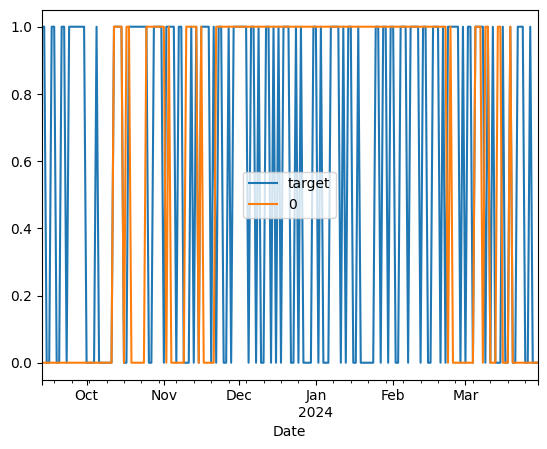

In [51]:
combined = pd.concat([test_df['target'], predictions], axis = 1)
combined.plot()

In [56]:
def predict(train_df, test_df, predictors, model):
    model.fit(train_df[predictors], train_df['target'])
    predictions = model.predict(test_df[predictors])
    predictions = pd.Series(predictions, index = test_df.index, name = "predictions")
    combined = pd.concat([test_df['target'], predictions], axis =1)
    return combined

def backtest(data, model, predictors, start = 90, step = 7):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train_df = data.iloc[0:i].copy()
        test_df = data.iloc[i:(i + step)].copy()
        predictions = predict(train_df, test_df, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
    # return all_predictions

In [57]:
pred_x =  ['close', 'open', 'high', 'low']
predictions = backtest(df_asset, model, predictors=pred_x)

In [58]:
predictions

,target,predictions
Date,,
2021-06-29,1,1
2021-06-30,0,1
2021-07-01,1,1
2021-07-02,1,1
2021-07-03,1,1
...,...,...
2024-03-26,0,0
2024-03-27,1,0
2024-03-28,0,0


In [61]:
predictions['predictions'].value_counts()
precision_score(predictions['target'], predictions['predictions'])

0.5311111111111111

In [62]:
predictions['target'].value_counts() / predictions.shape[0]

1    0.500994
0    0.499006
Name: target, dtype: float64